In [3]:
import numpy as np
import scipy
import scipy.special as sp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from clebschgordan import *
from wigner3j import *
from C_jlp import *
from matplotlib import rc
from mie_coefs import *
from focused_beams_class import *
from domain_class import *
from Multipoles import *




## Define Standard Units
fsize = 22
tsize = 15
tdir = 'in'
major = 5
minor = 3
style = 'default'

params = {
    'figure.figsize': (15,12),
    'savefig.dpi': 75,
    'text.usetex': False,
    'font.size': fsize,
    'legend.fontsize': tsize,
    'legend.title_fontsize': tsize,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral',    
    'axes.labelsize':15,
    'axes.titlesize':20,
    'lines.linewidth':2.5,
    'axes.grid': False,
    'axes.labelweight':'bold',
    'legend.loc': 'upper right',
    'xtick.labelsize':'x-small',
    'ytick.labelsize':'x-small',
}
plt.rcParams.update(params)

ModuleNotFoundError: No module named 'clebschgordan'

In [ ]:
import numba
import scipy
import numba_scipy

print("Numba version:", numba.__version__)
print("SciPy version:", scipy.__version__)
print("Numba-Scipy version:", numba_scipy.__version__)

Numba version: 0.61.0
SciPy version: 1.15.2
Numba-Scipy version: 0.2.0


In [4]:
import numba_special


ModuleNotFoundError: No module named 'numba_special'

In [2]:
def d_jmp(j, m, p, Theta):
    # p = m'
    M = max(abs(m), abs(p))
    N = min(abs(m), abs(p))
    
    lnCoef = 0.5 * (sp.gammaln(j - M + 1) + sp.gammaln(j + M + 1) - sp.gammaln(j + N + 1) - sp.gammaln(j - N + 1))

    cosFac = np.cos(Theta / 2) ** (abs(m + p))
    sinFac = (np.sin(Theta / 2)) ** (abs(m-p)) ## p-m? 
    
    n = j - M
    alpha = abs(m - p)
    beta = abs(m + p)
    hyp = sp.eval_jacobi(n, alpha, beta, np.cos(Theta))
    
    if hyp == 0:
        d_jmp = 0
    else:
        d_jmp = np.exp(lnCoef) * cosFac * sinFac * hyp * (-1) ** (0.5*(p-m-abs(m-p)))
    
    return d_jmp

def D_jmp(j, m, p, alpha, beta, gamma):
    fac1 = np.exp(-1j * m * alpha)
    fac2 = d_jmp(j, m, p, beta)
    fac3 = np.exp(-1j * p * gamma)
    return fac1 * fac2 * fac3

#initialize domain
size = 4
planes = {'xy', 'xz', 'yz'}
d = domain(size, planes)

wl = 0.632
jmax = 90

foc = focused_beams("LaguerreGauss", jmax, wl, d, NA=0.9, f=1000, n_lens=1)

NameError: name 'domain' is not defined

\begin{align*}
    D_{m^{\prime}m}^j(\alpha\beta\gamma)=e^{-im^{\prime}\alpha}d_{m^{\prime}m}^j(\beta)e^{-im\gamma}
\end{align*}

In [29]:
foc.C_jlp(l = 0, p = 1, q = 0)

(array([ 0.00000000e+00+0.00000000e+00j, -8.59724207e-02-4.75283797e-01j,
        -6.46509638e-02-3.57411776e-01j, -4.20938555e-02-2.32708668e-01j,
        -2.39920929e-02-1.32636175e-01j, -1.25390254e-02-6.93198536e-02j,
        -6.63341162e-03-3.66716796e-02j, -3.77602428e-03-2.08751033e-02j,
        -2.01379212e-03-1.11329047e-02j, -6.86850420e-04-3.79713486e-03j,
         6.19839296e-05+3.42667534e-04j,  1.40548013e-04+7.76995609e-04j,
        -1.29010657e-04-7.13213310e-04j, -2.81204826e-04-1.55459270e-03j,
        -1.34620083e-04-7.44224065e-04j,  1.18659658e-04+6.55989591e-04j,
         2.00021521e-04+1.10578471e-03j,  5.51721216e-05+3.05009621e-04j,
        -1.25540655e-04-6.94030003e-04j, -1.44675170e-04-7.99811889e-04j,
        -5.14647401e-06-2.84513998e-05j,  1.22560187e-04+6.77552992e-04j,
         1.03731042e-04+5.73459294e-04j, -2.29465942e-05-1.26856315e-04j,
        -1.08691307e-04-6.00881267e-04j, -6.63050410e-05-3.66556058e-04j,
         4.42510088e-05+2.44634120e-04

The (2j+1)Cjm_z normalization yields 1.996755
The LG integral on the aplanatic lens surface is 0.998



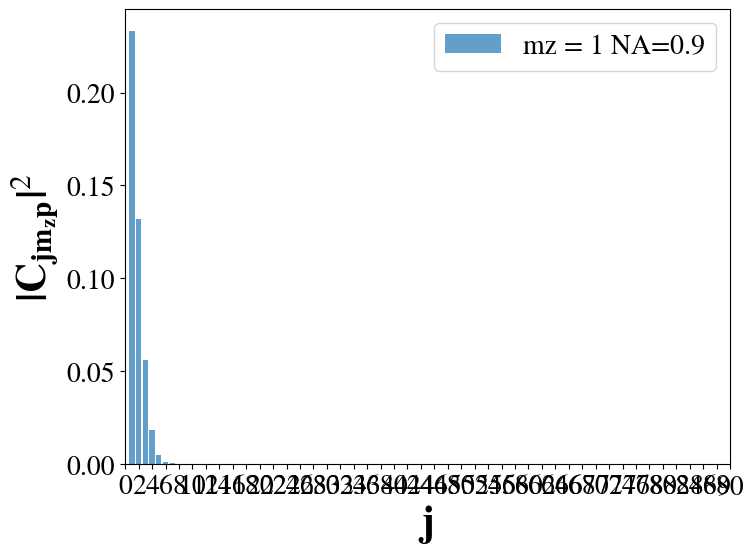

In [11]:
C_on = foc.C_jlp(l = 0, p = 1, q = 0)
foc.plot_Cjl(l = 0, p = 1, q = 0)

In [235]:
#@njit
def process_d(d):
    """ 
    Decompose d into a magnitude and two rotation angles: 
        polar (theta) and azimuthal (phi)
    Parameters:
        d: numpy array of shape (3,) specifying the cartesian coordinates
    Returns:
        d: float: magnitude of d
        theta: float: polar angle in radians
        phi: float: azimuthal angle in radians
    """
    # Check if d is a numpy array
    if not isinstance(d, np.ndarray):
        d = np.array(d)
    # Check if d has the correct shape
    if d.shape != (3,):
        raise ValueError("Input array must have shape (3,)")
    if np.linalg.norm(d) == 0:
        print("displacement is zero")
        return 0, 0, 0
    else:
        mag = np.linalg.norm(d)
        d = d / mag # normalize
        # Calculate the angles
        theta = np.arccos(d[2])
        phi = np.arctan2(d[1], d[0])
        
        return mag, theta, phi       

In [240]:
d = np.array([0, 0, 2])
m, theta, phi = process_d(d)
print(m, theta, phi)

2.0 0.0 0.0


\begin{align*}
    C_{j,m_z,p}^{off,\mathbf{d}} = \sum_{n=-\min (j, j^{\prime})}^{\min (j, j^{\prime})} \sum_{L=0}^\infty
    (2L+1)(-i)^L j_L(kd) \times
    \braket{j, n; L,0|j^\prime,n}\braket{j, p; L,0|j^\prime,p}
    \sum_{j^\prime=m_z^*}^\infty D^j_{m_z n}(\mathrm{\hat{d}})D^j_{m_z^* n}(\mathrm{\hat{d}}) C_{j^\prime m_z^* p}^{on}
\end{align*}

If the displacement is along z:
\begin{align*}
    C_{j,m_z,p}^{off,\mathbf{d}} =  \sum_{j^\prime=m_z^*}^\infty C_{j^\prime m_z^* p}^{on} \sum_{L=0}^\infty
    (2L+1)(-i)^L j_L(kd) \times
    \braket{j, n; L,0|j^\prime,n}\braket{j, p; L,0|j^\prime,p}
\end{align*}

In [14]:
def get_Jl(L, x):
    return sp.spherical_jn(L, x)

In [15]:
# Store all matrices in a list
D_matrices = []

for j in range(1, 12):
    size = 2 * j + 1
    D_mat = np.zeros((size, size), dtype=complex)

    for m_idx, m in enumerate(range(-j, j + 1)):
        for n_idx, n in enumerate(range(-j, j + 1)):
            D_mat[m_idx, n_idx] = D_jmp(j, m, n, phi, theta, 0)
    
    D_matrices.append(D_mat)

In [18]:
def matrix_CGs(Lmax, jpmax, clebsch_gordan_func):
    """
    Compute CG1 and CG2 matrices for Clebsch-Gordan coefficients.
    
    Parameters:
    - Lmax: Maximum L value
    - jpmax: Maximum j' value
    - clebsch_gordan_func: Function to compute Clebsch-Gordan coefficients

    Returns:
    - CG1: 4D NumPy array with shape (jpmax+1, Lmax+1, jpmax+1, 2*min(i, j)+1)
    - CG2: 3D NumPy array with shape (jpmax+1, Lmax+1, jpmax+1)
    """
    CG1 = np.zeros((jpmax+1, Lmax+1, jpmax+1, 2*min(Lmax, jpmax)+1), dtype=np.complex128)
    CG2 = np.zeros((jpmax+1, Lmax+1, jpmax+1), dtype=np.complex128)

    for i in range(1, Lmax+1):  # Loop over i (1-based in MATLAB)
        for j in range(1, jpmax+1):  # Loop over j
            for k in range(jpmax+1):  # Loop over k
                nnk = 0  # Counter for index
                for l in range(-min(i, j), min(i, j) + 1):  # Loop over l
                    CG1[j, k, i, nnk] = clebsch_gordan_func(j, k, i, l, 0, l)
                    nnk += 1
                
                # Compute CG2 (fixed l=1)
                CG2[j, k, i] = clebsch_gordan_func(j, k, i, 1, 0, 1)

    return CG1, CG2

In [19]:
CG1, CG2 = matrix_CGs(jmax, jmax, clebsch_gordan)
#save CG1 and CG2 to file
np.savez('CG1_CG2.npz', CG1=CG1, CG2=CG2)


In [20]:
#load CG1 and CG2 from file
data = np.load('CG1_CG2.npz')
CG1 = data['CG1']
CG2 = data['CG2']
print("CG1 shape:", CG1.shape)
print("CG2 shape:", CG2.shape)

CG1 shape: (91, 91, 91, 181)
CG2 shape: (91, 91, 91)


In [ ]:
def compute_C_off(j_max, mz_star, k, d, C_on):
    """
    Compute C^off as a 2D array with:
    - j from 0 to j_max (axis 1)
    - m_z from -j_max to j_max (axis 2)
    
    Parameters:
    - j_max: Maximum j value
    - mz_star: Fixed m_z* value
    - k: Wavevector magnitude
    - d: Displacement vector (numpy array with shape (3,))
    - C_on: Known C^on values (1D array, indexed by j')

    Returns:
    - C_off: 2D array of shape (j_max+1, 2*j_max+1)
    """
    # Process displacement vector into spherical coordinates
    mag, theta, phi = process_d(d)

    #initialize Lvals
    Lvals = np.arange(0, j_max + 1)
    gjmp=np.zeros((jmax-(mz_star-1),jmax,2*jmax+1), dtype=np.complex128)  # Initialize gjmp array
    
    # use simpler expression for displacement along z
    if theta == 0:
        # Outer loop over j'
        for j_prime in range(max(abs(mz_star), 1), j_max + 1):
            for j in range(1, j_max + 1):  # Outer loop over j (start from 1 to match MATLAB)
                n1 = 0
                for m_z in range(j, -j - 1, -1):
                    Lfac = (2 * Lvals + 1) * (-1j)**Lvals * get_Jl(Lvals, k * mag)

                    # Compute gjmpi factor
                    gjmpi = (Lfac[:, None] * 
                            ((CG1[j, Lvals, j_prime, 0:2*min(j, j_prime)+1].conj().squeeze()) * CG2[j, Lvals, j_prime][:, None])
                        ) #shape (2*mz+1, jmax+1)
        
                    # Compute Wigner matrix products (corresponding to AA and BB terms in MATLAB)
                    gjmp[j_prime-mz_star, j-1, n1] = np.sum(np.conj(np.sum(gjmpi, axis=0).T), axis = 0)

                    n1 += 1
    
    else:
        #calculate the Wigner D matrices for each j
        D_matrices = []
        
        for jj in range(1, j_max + 1):
            size = 2 * jj + 1
            D_mat = np.zeros((size, size), dtype=complex)

            for m_idx, m in enumerate(range(-jj, jj + 1)):
                for n_idx, n in enumerate(range(-jj, jj + 1)):
                    D_mat[m_idx, n_idx] = D_jmp(jj, m, n, phi, theta, 0)
            
            D_matrices.append(D_mat) #each element is a matrix of size (2*jj+1, 2*jj+1)
            

        # Outer loop over j'
        for j_prime in range(max(abs(mz_star), 1), j_max + 1):
            A = D_matrices[j_prime-1]
            ii2 = j_prime - mz_star  # Adjust indexing
            for j in range(1, j_max + 1):  # Outer loop over j (start from 1 to match MATLAB)
                B = D_matrices[j-1]
                n1 = 0

                nn = np.arange(-min(j, j_prime), min(j, j_prime) + 1) 
                for m_z in range(j, -j - 1, -1):
                    Lfac = (2 * Lvals + 1) * (-1j)**Lvals * get_Jl(Lvals, k * mag)

                    # Compute gjmpi factor
                    gjmpi = (Lfac[:, None] * 
                            ((CG1[j, Lvals, j_prime, 0:2*min(j, j_prime)+1].conj().squeeze()) * CG2[j, Lvals, j_prime][:, None])
                        ) #shape (2*mz+1, jmax+1)

                    ii3 = j - m_z  # Adjust indexing
                    nn = np.arange(-min(j, j_prime), min(j, j_prime) + 1)  
                    DJ = A[ii2, j_prime-nn] #shape(2*jmax+1,)
                    DJp = B[ii3, j-nn] 

        
                    # Compute Wigner matrix products (corresponding to AA and BB terms in MATLAB)
                    gjmp[j_prime-mz_star, j-1, n1] = np.sum((np.conj(np.sum(gjmpi, axis=0).T *DJ.conj()*DJp)), axis = 0) 

                    n1 += 1

    Gjmp = np.sum((C_on.conj())[1:,None,None] * gjmp, axis=0) # shape(jmax, 2*jmax+1)
    
    return Gjmp


In [244]:
d = np.array([0, 1, 0]) #displacement along y
jmax = 20
k = 2*np.pi / wl
l = 0; p = 1; q = 0
mz_star = l+p
C_on = foc.C_jlp(l, p, q)[0][:jmax+1]
Gjmp = compute_C_off(jmax, mz_star, k, d, C_on)
C_off = np.abs(Gjmp)**2

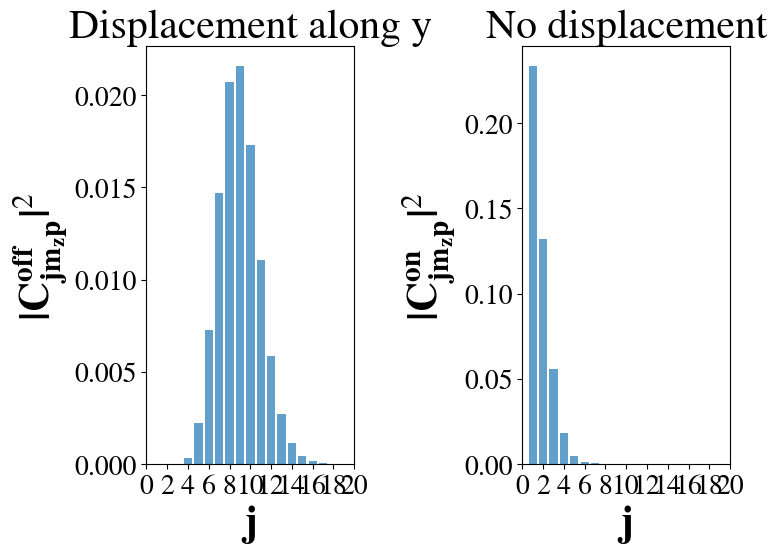

In [245]:
#plot C_off
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].bar(np.arange(1, len(C_off)+1), np.sum(C_off,1), alpha=0.7)
ax[0].set_ylabel(r"$\mathbf{|C^{off}_{jm_zp}|}^2$", fontsize=30)
ax[0].set_xlabel('j', fontsize=30)
ax[0].set_xlim(0, jmax)
ax[0].set_xticks(range(0, jmax + 1, 2))  # Set x-ticks to increase in steps of 2
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_title("Displacement along y", fontsize=30)
ax[1].bar(np.arange(1, len(C_off)+1), np.abs(C_on[1:])**2, alpha=0.7)
ax[1].set_ylabel(r"$\mathbf{|C^{on}_{jm_zp}|}^2$", fontsize=30)
ax[1].set_xlabel('j', fontsize=30)
ax[1].set_xlim(0, jmax)
ax[1].set_xticks(range(0, jmax + 1, 2))  # Set x-ticks to increase in steps of 2
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_title("No displacement", fontsize=30)

fig.tight_layout()
plt.show()

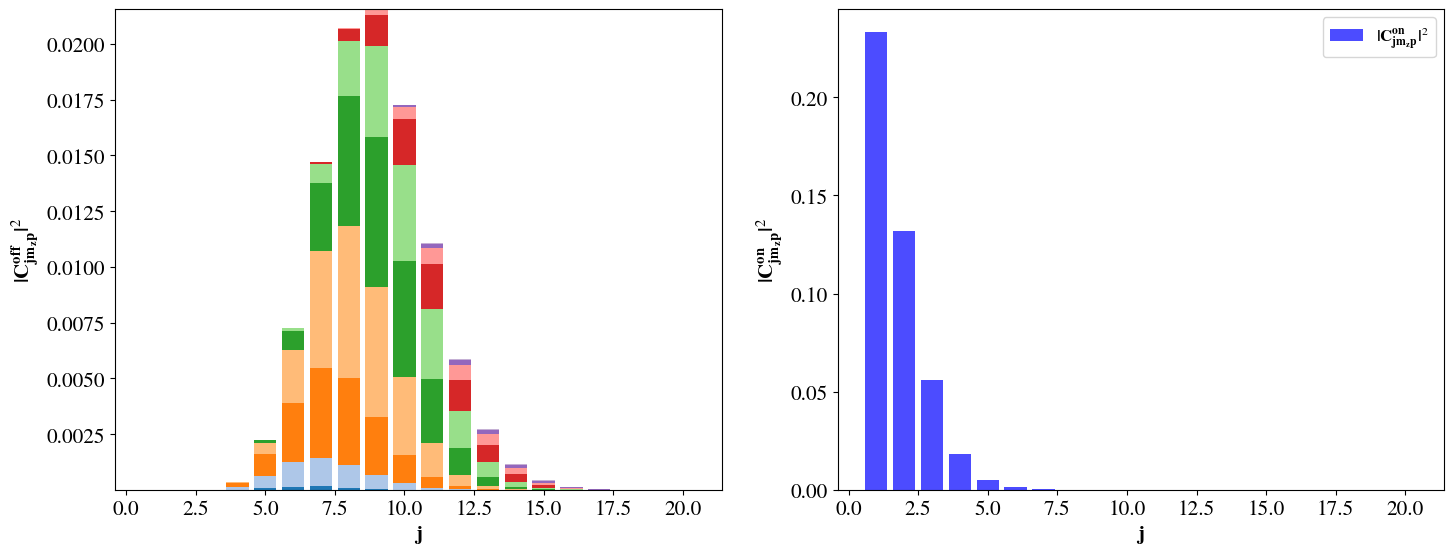

In [202]:
# Plot stacked histogram and C_on in a (1, 2) subplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Transpose C_off to stack along the rows
C_off_transposed = C_off.T

# Define more distinctive colors using the tab20 colormap
colors = plt.cm.tab20(np.linspace(0, 1, C_off_transposed.shape[0]))

# Create the stacked histogram in the first subplot
ax[0].bar(np.arange(1,C_off_transposed.shape[1]+1),
    C_off_transposed[0],
    color=colors[0]
)
for i in range(1, C_off_transposed.shape[0]):
    ax[0].bar(
        np.arange(1,C_off_transposed.shape[1]+1),
        C_off_transposed[i],
        bottom=np.sum(C_off_transposed[:i], axis=0),
        color=colors[i]
    )

# Add title and axis labels for the first subplot
ax[0].set_xlabel('j', fontsize=15)
ax[0].set_ylabel(r"$\mathbf{|C^{off}_{jm_zp}|}^2$", fontsize=15)

# Create the histogram for C_on in the second subplot
ax[1].bar(
    np.arange(1, len(C_on)),
    np.abs(C_on[1:])**2,
    color='blue',
    alpha=0.7,
    label=r"$\mathbf{|C^{on}_{jm_zp}|}^2$"
)

# Add title, axis labels, and legend for the second subplot
ax[1].set_xlabel('j', fontsize=15)
ax[1].set_ylabel(r"$\mathbf{|C^{on}_{jm_zp}|}^2$", fontsize=15)
ax[1].legend(fontsize=12)

# Adjust layout and show the plot
fig.tight_layout()
plt.show()

In [150]:
print(np.sum(C_off, axis=1))

[2.08964757e-07 3.49080885e-07 1.56108578e-07 3.27044103e-07
 3.31791266e-07 1.94302237e-07 4.34113901e-07 3.69866542e-07
 2.48669523e-07 6.49327676e-07 4.61045384e-07 3.73539460e-07
 1.10658730e-06 6.48230028e-07 6.14980663e-07 2.17858986e-06
 1.19939510e-06 1.01350292e-06 4.88122006e-06 3.31590947e-06
 1.21234093e-06 1.14244802e-05 1.32827396e-05 1.25844238e-06
 1.96371228e-05 5.33516744e-05 2.98457985e-05 4.83143223e-06
 1.07089828e-04 2.47620169e-04 1.96153693e-04 2.08386611e-05
 1.61840160e-04 9.56878044e-04 2.24683501e-03 3.50032798e-03
 4.21373617e-03 4.18861286e-03 3.55873008e-03 2.63952790e-03
 1.73835170e-03 1.03495502e-03 5.66965198e-04 2.88408296e-04
 1.35513445e-04 5.81392711e-05 2.28131027e-05 8.46536174e-06
 3.16677762e-06 1.22719423e-06]


In [226]:
# Rotate to X basis
def transform_to_mx_basis(C_off_mz, j_max):
    """
    Transforms C_off from the m_z basis to the m_x basis.

    Parameters:
    - C_off_mz: 2D array of shape (j_max+1, 2*j_max+1), values in the m_z basis
    - j_max: maximum j
    - d_matrix_func: function (j, mx, mz, beta) → d^j_{mx mz}(beta)

    Returns:
    - C_off_mx: 2D array of same shape as C_off_mz but in m_x basis
    """
    C_off_mx = np.zeros_like(C_off_mz, dtype=np.complex128)
    
    D_matrices = []

    for jj in range(1, np.shape(C_off_mz)[0]):
        size = 2 * jj + 1
        D_mat = np.zeros((size, size), dtype=complex)

        for m_idx, m in enumerate(range(-jj, jj + 1)):
            for n_idx, n in enumerate(range(-jj, jj + 1)):
                D_mat[m_idx, n_idx] = d_jmp(jj, m, n, np.pi/2)       
        D_matrices.append(D_mat)
    for jj in range(1, np.shape(C_off_mz)[0]):
        D_mat = D_matrices[jj-1]
        cx = 0
        for m_x in range(jj, -jj - 1, -1):
            C_off_mx[jj-1, cx] = np.sum(C_off_mz[jj-1, :2*jj] * D_mat[cx, :2*jj])
            cx += 1
    return C_off_mx


In [227]:
D_matrices = []

for jj in range(1, np.shape(C_off)[0]):
        size = 2 * jj + 1
        D_mat = np.zeros((size, size), dtype=complex)

        for m_idx, m in enumerate(range(-jj, jj + 1)):
            for n_idx, n in enumerate(range(-jj, jj + 1)):
                D_mat[m_idx, n_idx] = d_jmp(jj, m, n, np.pi/2)
        D_matrices.append(D_mat)

In [232]:
C_off_mx = transform_to_mx_basis(Gjmp, jmax)
C_off_mx = np.abs(C_off_mx)**2

In [233]:
C_on_mx = np.zeros((jmax + 1, 2 * jmax + 1), dtype=np.complex128)
for j in range(jmax + 1):
    m_vals = np.arange(-j, j + 1)
    for idx, mx in enumerate(m_vals):
        d = d_jmp(j, mx, p, -np.pi / 2)
        C_on_mx[j, jmax + mx] = d * C_on[j]

/var/folders/1z/l3vglvzx4212kv0yl2rk_mjr0000gn/T/ipykernel_16430/2309181232.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(fontsize=12)


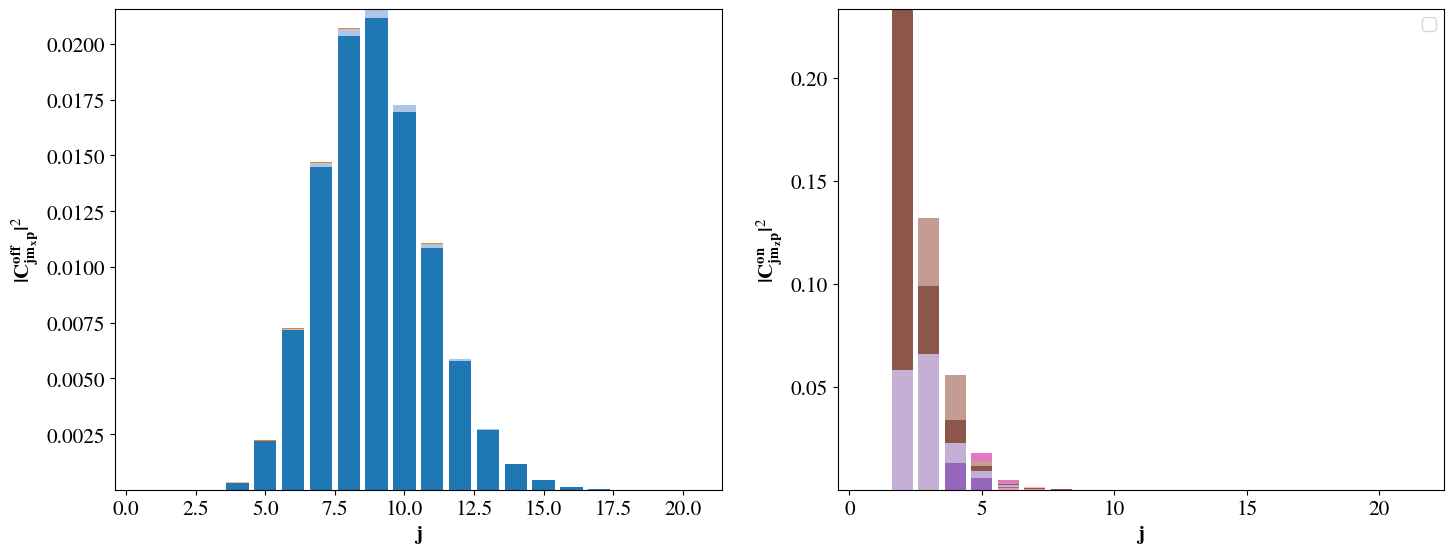

In [234]:
# Plot stacked histogram and C_on in a (1, 2) subplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Transpose C_off_mx to stack along the rows
C_off_mx_transposed = C_off_mx.T

# Define more distinctive colors using the tab20 colormap
colors = plt.cm.tab20(np.linspace(0, 1, C_off_mx_transposed.shape[0]))

# Create the stacked histogram in the first subplot
ax[0].bar(np.arange(1, C_off_mx_transposed.shape[1] + 1),
    C_off_mx_transposed[0].real,
    color=colors[0]
)
for i in range(1, C_off_mx_transposed.shape[0]):
    ax[0].bar(
        np.arange(1, C_off_mx_transposed.shape[1] + 1),
        C_off_mx_transposed[i].real,
        bottom=np.sum(C_off_mx_transposed[:i].real, axis=0),
        color=colors[i]
    )

# Add title and axis labels for the first subplot
ax[0].set_xlabel('j', fontsize=15)
ax[0].set_ylabel(r"$\mathbf{|C^{off}_{jm_xp}|}^2$", fontsize=15)

# Stack C_on_mx equivalently in the second subplot
C_on_mx_stacked = np.array([np.abs(C_on_mx[j])**2 for j in range(len(C_on_mx))]).T

# Define more distinctive colors using the tab20 colormap
colors_on_mx = plt.cm.tab20(np.linspace(0, 1, C_on_mx_stacked.shape[0]))

# Create the stacked histogram for C_on_mx
ax[1].bar(np.arange(1, C_on_mx_stacked.shape[1] + 1),
    C_on_mx_stacked[0],
    color=colors_on_mx[0]
)
for i in range(1, C_on_mx_stacked.shape[0]):
    ax[1].bar(
        np.arange(1, C_on_mx_stacked.shape[1] + 1),
        C_on_mx_stacked[i],
        bottom=np.sum(C_on_mx_stacked[:i], axis=0),
        color=colors_on_mx[i]
    )

# Add title, axis labels, and legend for the second subplot
ax[1].set_xlabel('j', fontsize=15)
ax[1].set_ylabel(r"$\mathbf{|C^{on}_{jm_zp}|}^2$", fontsize=15)
ax[1].legend(fontsize=12)

# Adjust layout and show the plot
fig.tight_layout()
plt.show()